In [1]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "FriendsScripts.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "thebumpkin/ultimate-friends-tv-sitcom-dataset",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/tmp/ipython-input-2965552990.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 1.33M/1.33M [00:01<00:00, 1.35MB/s]

Extracting zip of FriendsScripts.csv...
First 5 records:    Number  Season  Episode Character  \
0     101       5        4    Monica   
1     101       5        4    Rachel   
2     101       5        4    Monica   
3     101       5        4    Rachel   
4     101       5        4    Monica   

                                                Text  
0                Come in. I've been waiting for you.  
1   Hi! I just wanna--Ahhh!!! Oh my God!  Oh my God!  
2  Okay, I'm sorry! I'm sorry! I-I-I was um, I wa...  
3  Since when do take naps in that position. Oh G...  
4  Yes. Yes, I was. A guy. From work.  I'm seeing...  


In [2]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 108.5 MB/s eta 0:00:00


In [3]:
import gensim
from gensim.models import Word2Vec

# 1. Clean and Tokenize the data
# We apply a simple preprocessor to every row in the 'Text' column
# This converts "Oh my God!" -> ['oh', 'my', 'god']
corpus = df['Text'].apply(lambda x: gensim.utils.simple_preprocess(str(x)))

# Check the first few entries to see the difference
print(f"Original: {df['Text'].iloc[1]}")
print(f"Tokenized: {corpus.iloc[1]}")

Original: Hi! I just wanna--Ahhh!!! Oh my God!  Oh my God!
Tokenized: ['hi', 'just', 'wanna', 'ahhh', 'oh', 'my', 'god', 'oh', 'my', 'god']


In [5]:
# 2. Initialize and Train Word2Vec
model = Word2Vec(
    sentences=corpus,      # The list of tokenized sentences
    vector_size=300,       # Dimensionality of the embedding vector (100-300 is standard)
    window=5,              # Context window: How many words neighbors to look at
    min_count=5,           # Ignore words that appear fewer than 5 times (filters typos/names)
    workers=4,             # Number of CPU cores to use for training
    sg=0,                  # 0 = CBOW (faster), 1 = Skip-gram (better for infrequent words)
    epochs=10              # How many times to iterate over the dataset
)

print("Training complete!")

Training complete!


In [6]:
# Find words most similar to 'joey'
# You might expect: 'chandler', 'food', 'pizza', or 'tribbiani'
print("Words like Joey:", model.wv.most_similar('joey'))

# Find words like 'coffee'
# You might expect: 'perk', 'latte', 'central'
print("Words like Coffee:", model.wv.most_similar('coffee'))

# Analogy: "Ross" is to "Rachel" as "Chandler" is to ___?
# Result should ideally be 'monica'
try:
    result = model.wv.most_similar(positive=['chandler', 'rachel'], negative=['ross'], topn=1)
    print(f"Ross : Rachel :: Chandler : {result[0][0]}")
except KeyError as e:
    print(f"Word not found in vocabulary: {e}")

Words like Joey: [('chandler', 0.7093062400817871), ('ross', 0.7008182406425476), ('rachel', 0.608325183391571), ('monica', 0.5902794599533081), ('phoebe', 0.5818974375724792), ('tribbiani', 0.5161345601081848), ('janice', 0.5111644268035889), ('charlie', 0.4937776029109955), ('emily', 0.4813660979270935), ('mike', 0.4500562250614166)]
Words like Coffee: [('cup', 0.8433699607849121), ('ice', 0.7186537384986877), ('cake', 0.7170584797859192), ('house', 0.7006573677062988), ('extra', 0.6700249314308167), ('tea', 0.6657996773719788), ('glass', 0.6608933806419373), ('ball', 0.6468883156776428), ('piece', 0.6412375569343567), ('box', 0.6399024724960327)]
Ross : Rachel :: Chandler : monica


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


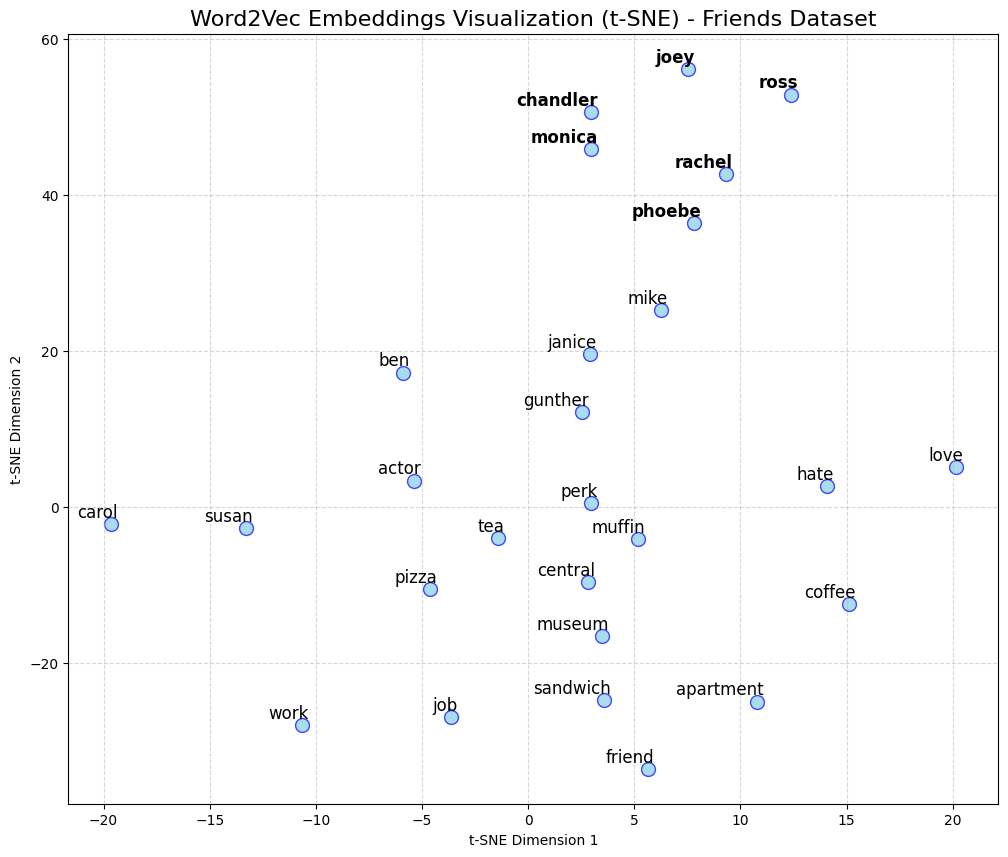

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# 1. Define the words you want to visualize
# We select main characters, key objects, and concepts to see how they cluster
target_words = [
    'joey', 'chandler', 'ross', 'rachel', 'monica', 'phoebe',  # The Gang
    'gunther', 'janice', 'mike', 'carol', 'susan', 'ben',      # Side characters
    'coffee', 'tea', 'pizza', 'sandwich', 'muffin',            # Food
    'love', 'hate', 'friend', 'work', 'job',                   # Concepts
    'central', 'perk', 'apartment', 'museum', 'actor'          # Places/Jobs
]

# 2. Extract vectors from your trained model
# We filter out words that might not be in the vocabulary (min_count=5)
valid_words = [word for word in target_words if word in model.wv]
word_vectors = np.array([model.wv[word] for word in valid_words])

# 3. Reduce Dimensions (100D -> 2D)
# We use t-SNE, which is better at preserving local neighborhoods than PCA
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=1000)
vectors_2d = tsne.fit_transform(word_vectors)

# 4. Plotting
plt.figure(figsize=(12, 10))

# Create the scatter plot
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c='skyblue', s=100, edgecolors='b', alpha=0.7)

# Annotate each point with its word
for i, word in enumerate(valid_words):
    # Make the main cast bold for visibility
    font_weight = 'bold' if word in ['joey', 'chandler', 'ross', 'rachel', 'monica', 'phoebe'] else 'normal'

    plt.annotate(
        word,
        xy=(vectors_2d[i, 0], vectors_2d[i, 1]),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom',
        fontsize=12,
        fontweight=font_weight
    )

plt.title('Word2Vec Embeddings Visualization (t-SNE) - Friends Dataset', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()